In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mne.io import read_raw_brainvision

from neurodsp.filt import filter_signal

from bycycle.features import compute_features
from bycycle.group import compute_features_2d
from bycycle.cyclepoints import find_extrema, find_zerox
from bycycle.cyclepoints.zerox import find_flank_zerox
from bycycle.plts import plot_burst_detect_summary, plot_cyclepoints_array

pd.options.display.max_columns = 10

In [2]:
def get_time_interval(annotation_file_name):
    """
    load the annotation file
    """
    # create time segments for cutting overlapping windows
    df_events               = pd.read_csv(annotation_file_name)

    # since we don't want to have too many "normal" data (labeled 0),
    # we cut off the last part of EEG when no particular events
    spindle_events          = df_events[df_events['Annotation'] == 'spindle']
    kcomplex_events         = df_events[df_events['Annotation'] == 'k-complex']
    stage_2_sleep_events    = df_events[df_events['Annotation'].apply(lambda x: np.logical_or(
                                            'Markon: 2' in x, 'Markoff: 2' in x))]

    tmin = 0
    # we only look at the data from when the first 2nd stage sleep started
    if len(stage_2_sleep_events) > 1:
        print('stage 2 sleep annotations are provided')
        tmin = np.min(stage_2_sleep_events['Onset'].values)
    
    # and we stop looking at the data when the last spindle, kcomplex, or 2nd stage stops,
    # whichever one happens the latest
    spindle_max = spindle_events['Onset'].values
    spindle_max = spindle_max if spindle_max.any() else np.zeros(1)
    kcomplex_max = kcomplex_events['Onset'].values
    kcomplex_max = kcomplex_max if kcomplex_max.any() else np.zeros(1)
    stage_2_max = stage_2_sleep_events['Onset'].values
    stage_2_max = stage_2_max if stage_2_max.any() else np.zero(1)
    
    tmax = np.max([spindle_max.max(), kcomplex_max.max() + 1, stage_2_max.max() + 1])
    return tmin, tmax

stage 2 sleep annotations are provided
Reading 0 ... 1055034  =      0.000 ...  1055.034 secs...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


Using matplotlib as 2D backend.


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.6s finished


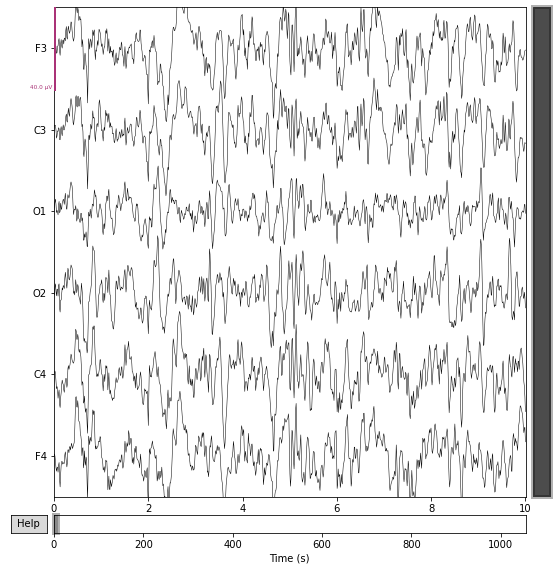

In [3]:
fname_raw = './EEG/suj11_l2nap_day2.vhdr'
channelList = ['F3', 'F4', 'C3', 'C4', 'O1', 'O2']
tmin, tmax = get_time_interval('./annotations/suj11_day2_annotations.txt')

raw  = read_raw_brainvision(fname_raw, verbose=0)
raw  = raw.crop(tmin, tmax)
raw  = raw.pick_channels(channelList)
filt = raw.load_data().filter(1, 30, verbose=0)
filt.plot();

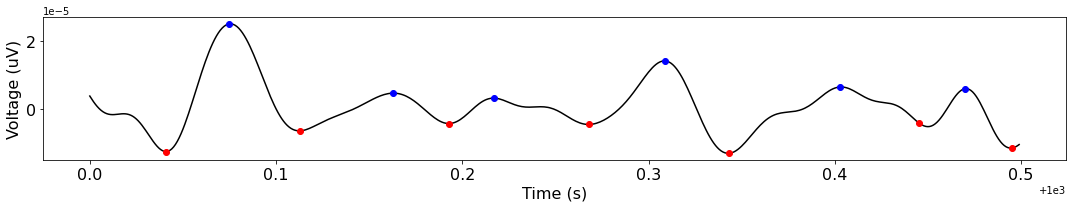

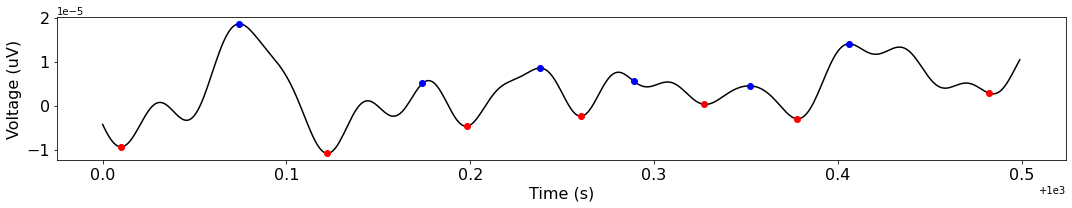

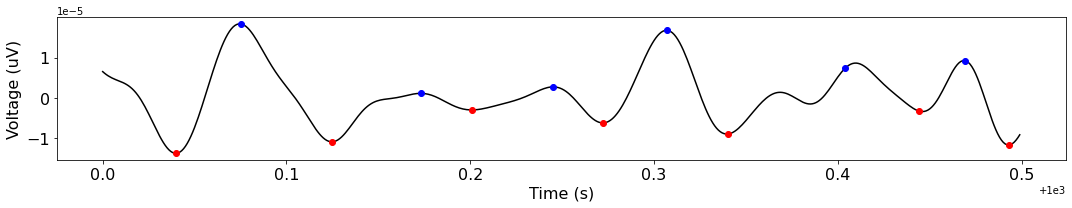

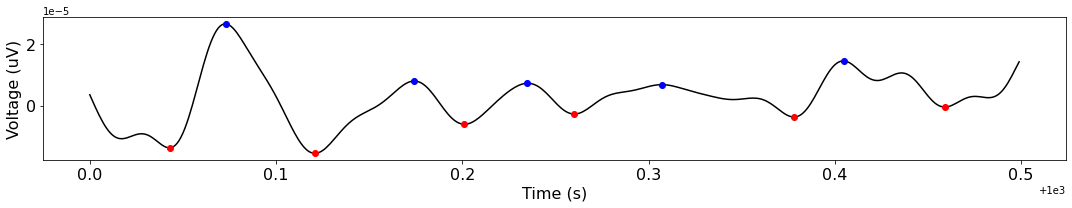

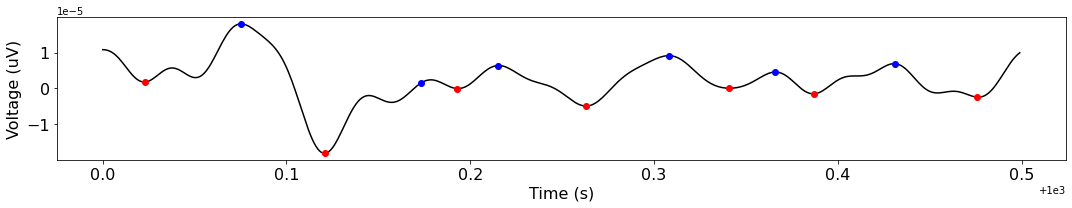

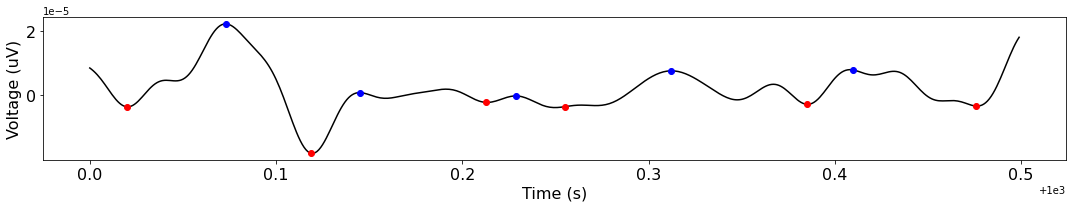

In [10]:
# sig = load_bycycle_data('ca1.npy', folder='data')
fs = 1000


# Filter settings
f_spind = (11, 16)
f_lowpass = 30
xlim = (1000, 1000.5)

# Load data
for pick in channelList:
    sig = filt.get_data(picks=[pick]).flatten()
    # n_seconds_filter = 0.1

    # # Lowpass filter
    # sig_low = filter_signal(sig, fs, 'lowpass', f_lowpass,
    #                         n_seconds=n_seconds_filter, remove_edges=False)

    # # Plot signal
    # times = np.arange(0, len(sig)/fs, 1/fs)
    # tidx = np.logical_and(times >= xlim[0], times < xlim[1])

    # plot_time_series(times[tidx], sigs=[sig[tidx], sig_low[tidx]], colors=['k', 'k'], alpha=[.5,1], lw=2)
    # plt.title(f'{pick}')

    # Narrowband filter signal
    n_seconds_spind = 1.25
    sig_narrow = filter_signal(sig, fs, 'bandpass', f_spind,
                               n_seconds=n_seconds_spind, remove_edges=False)

    # Find rising and falling zerocrossings (narrowband)
    rise_xs = find_flank_zerox(sig_narrow, 'rise')
    decay_xs = find_flank_zerox(sig_narrow, 'decay')

    # Find peaks and troughs (this function also does the above)
    peaks, troughs = find_extrema(sig, fs, f_spind,
                                  filter_kwargs={'n_seconds':n_seconds_spind})

    rises, decays = find_zerox(sig, peaks, troughs)

    # plot_cyclepoints_array(sig, fs, peaks=peaks, troughs=troughs, rises=rises,
    #                        decays=decays, xlim=xlim)
    plot_cyclepoints_array(sig, fs, peaks=peaks, troughs=troughs, xlim=xlim)

    # Plot frequency response of bandpass filter
    # sig_filt = filter_signal(sig, fs, 'bandpass', f_spind, n_seconds=n_seconds_spind, plot_properties=True)
plt.show();

In [ ]:
df_features = compute_features(sig, fs, f_spind)
df_features

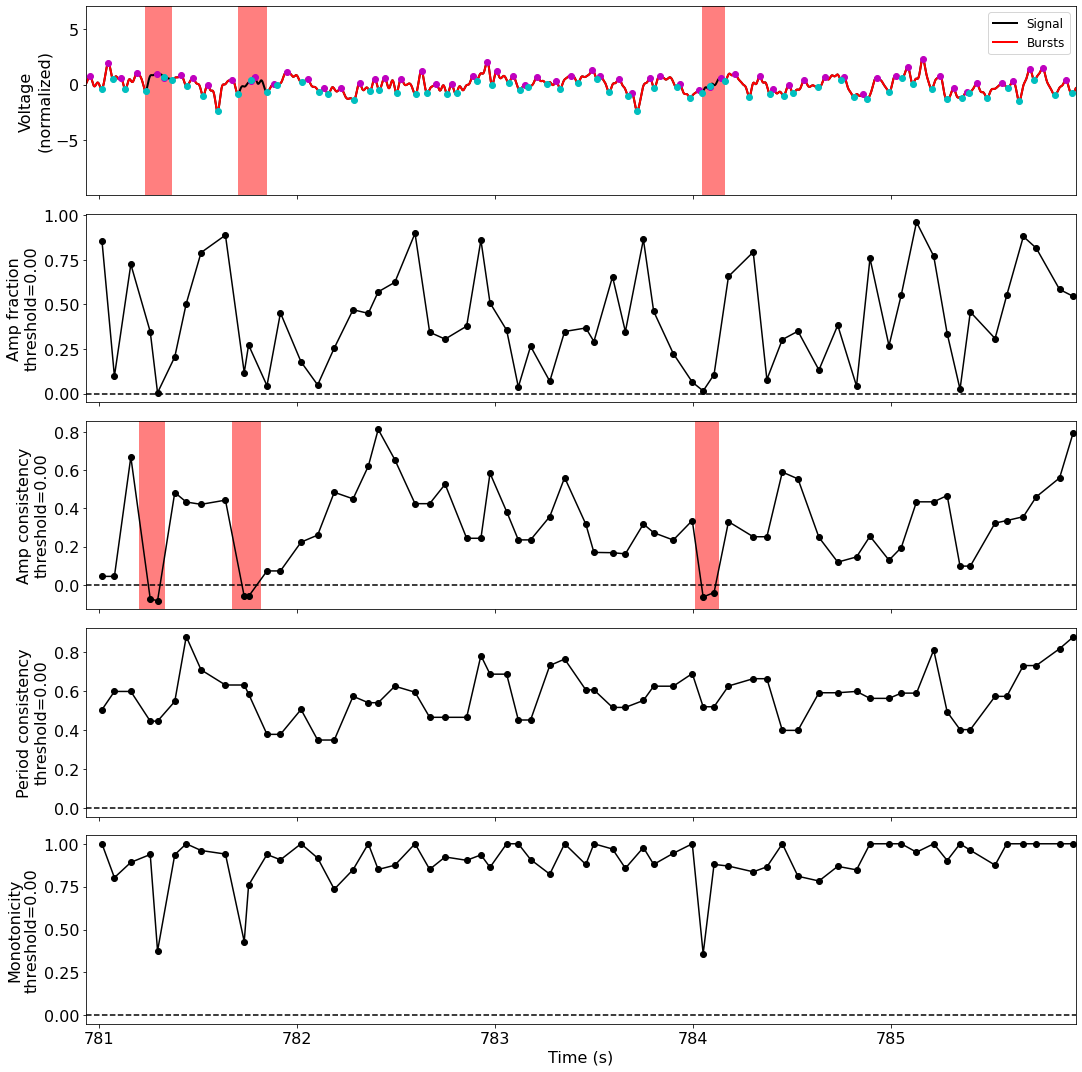

In [9]:
sig = filt.get_data(picks=['C4']).flatten()
fs = 1000
f_spind = (11, 16)
xlim = (780.9355829, 780.9355829+5)

threshold_kwargs = {'amp_fraction_threshold': 0,
                    'amp_consistency_threshold': 0,
                    'period_consistency_threshold': 0,
                    'monotonicity_threshold': 0,
                    'min_n_cycles': 0}

df_features = compute_features(sig, fs, f_spind, threshold_kwargs=threshold_kwargs)

plot_burst_detect_summary(df_features, sig, fs, threshold_kwargs, xlim=xlim)
plt.show()

In [ ]:
plot_burst_detect_summary(df_features, sig, fs, threshold_kwargs, xlim=(1476, 1481))
plt.show()

In [ ]:
sigs = filt.get_data()
fs = 1000
f_range = (11, 16)

thresholds = dict(amp_fraction_threshold=0.2,
                  amp_consistency_threshold=0.25,
                  period_consistency_threshold=0.5,
                  monotonicity_threshold=0.75,
                  min_n_cycles=3.)

compute_kwargs = {'burst_method': 'cycles', 'threshold_kwargs': thresholds}

df_features_2d = compute_features_2d(sigs, fs, f_range, compute_features_kwargs=compute_kwargs, axis=None)

In [ ]:
plot_burst_detect_summary(df_features_2d[1], sigs[1], fs, thresholds, tmin=100, tmax=105)
plt.show()

In [ ]:
for i, df_feat in enumerate(df_features_2d):
    df_feat.to_csv(f'output_{i}.csv')

In [ ]:
cycle_cols = ['sample_peak',
              'sample_last_zerox_decay',
              'sample_zerox_decay',
              'sample_zerox_rise',
              'sample_last_trough',
              'sample_next_trough']
arr_2d = df_features_2d[3][cycle_cols]
arr_2d

In [ ]:
# Get onsets for annotated spindles
annotations = pd.read_csv('./annotations/suj11_day2_annotations.txt')
spindles = annotations[annotations['Annotation'] == 'spindle']
onsets = np.int32((spindles.Onset - tmin) * 1000)

# Check if each cycle is within
mins = np.min(arr_2d, axis=1) # Starts of cycles
maxs = np.max(arr_2d, axis=1) # End of cycles
spindle_search = np.array([[1 if ((t < _min < t+1250) or (t < _max < t+1250)) else 0 for t in onsets] for _min, _max in zip(mins, maxs)])
in_spindle = np.any(spindle_search, axis=1)

In [ ]:
in_spindle.astype(int)

In [ ]:
np.sum(in_spindle)